In [1]:
from ipywidgets import interact, IntSlider
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
matplotlib.rcParams['font.size'] = 14

# DC resistivity example: Gradient array with single source

## Purpose

- Explore the basic setup and physics of a direct current (DC) resistivity survey within the context of kimberlite exploration. 

- Run DC forward modelling and inversion using the SimPEG-Static package. 

## Setup

Physical behavior of DC resistivity survey is governed by steady-state maxwell's equation:

$$\vec{j} = \sigma \vec{e}$$

$$\vec{e} = -\nabla \phi$$

$$\nabla \cdot \vec{j} = -\vec{j}_s = I_0 (\delta(\vec{r}-\vec{r}_+)-\delta(\vec{r}-\vec{r}_-))$$

$$\vec{j} \cdot \hat{n} \ \Big|_{\partial \Omega} = 0$$ 

- $\vec{j}$: Current density (A/m $^2$)

- $\vec{e}$: Electric field (V/m)

- $I_0$: Current (A)

- $\delta$: Volumetric delta function (m $^{-3}$)

Consider a simple gradient array having a pair of A (+) and B (+) current electrodes as the transmitter (Tx) with multiple M (+) and N (-) potential electrode pairs for receivers (Rx). Using a current source (large battery or generator), we setup a significant potential difference between the A and B electrodes which allows electrial currents to flow from the A to B electrode. The presence of conductive or resistive structures within the earth distorts current flow and leads to the accumulation of charges on interfaces. The potential differences measured at each M and N electrode pair will be reflective on those chrage accumulations and current distortions. Forward modelling is the process by which we caluclate the potentials (or associated fields) that would result from a given conductivity model. Conversely, with the inverse problem we reconstruct the model from the observed data. 

Using a DC resitivity survey for diamond or mineral exploration is possible anytime that there is a suiteably large contrast in conductivity between the target and host/background rock. In this example, the kimberlite doposits (which incorporate diamonds) are more conductive than the granitic background rock.

<img src="DCIP_kimberlites.png" width=500> </img>

## Forward problem

### Setup mesh, load model, design survey, and forward model data

In [ ]:
from SimPEG import Mesh, Utils, Maps, Survey
import numpy as np
from SimPEG.EM.Static import DC, IP, Utils as StaticUtils
from pymatsolver import PardisoSolver

### Mesh

# Core cell sizes in x, y, and z
csx, csy, csz = 25., 25., 25.
# Number of core cells in each directiPon s
ncx, ncy, ncz = 48, 48, 20
# Number of padding cells to add in each direction
npad = 7
# Vectors of cell lengthts in each direction
hx = [(csx,npad, -1.3),(csx,ncx),(csx,npad, 1.3)]
hy = [(csy,npad, -1.3),(csy,ncy),(csy,npad, 1.3)]
hz = [(csz,npad, -1.3),(csz,ncz), (csz/2.,6)]
# Create mesh
mesh = Mesh.TensorMesh([hx, hy, hz],x0="CCN")
# Map mesh coordinates from local to UTM coordiantes
xc = 300+5.57e5
yc = 600+7.133e6
zc = 425.
mesh._x0 = mesh.x0 + np.r_[xc, yc, zc]

# Load synthetic conductivity model matching the designated mesh
sigma = mesh.readModelUBC("VTKout_DC.dat")
# Identify air cells in the model
airind = sigma == 1e-8

# Generate background model (constant conductiivty below topography)
sigma0 = np.ones_like(sigma)*1e-4
sigma0[airind] = 1e-8

### Survey

# Obtain topographic surface from 3D conductivity model
mesh2D, topoCC = StaticUtils.gettopoCC(mesh, airind)

# Setup gradient array survey

# Define the source electrode locations
# Here we use a single dipole source (A-B electrode) in the x-direction)
Aloc1_x = np.r_[-600., 0, 0.] + np.r_[xc, yc, zc]
Bloc1_x = np.r_[600., 0, 0.] + np.r_[xc, yc, zc]

# Rx locations (M-N electrodes, x-direction)
# Find x and y cell centres in the interior portion of the mesh
x = mesh.vectorCCx[np.logical_and(mesh.vectorCCx>-300.+ xc, mesh.vectorCCx<300.+ xc)]
y = mesh.vectorCCy[np.logical_and(mesh.vectorCCy>-300.+ yc, mesh.vectorCCy<300.+ yc)]
# Grid selected cell centres to get M and N Rx electrode locations
Mx = Utils.ndgrid(x[:-1], y, np.r_[-12.5/2.])
Nx = Utils.ndgrid(x[1:], y, np.r_[-12.5/2.])
# Get cell ind for electrode locations to extract electrode elevation from topoCC
inds_Mx = Utils.closestPoints(mesh2D, Mx[:,:2])
inds_Nx = Utils.closestPoints(mesh2D, Nx[:,:2])
# Draped M and N electrode x,y,z locations
Mx_dr = np.c_[Mx[:,0], Mx[:,1], topoCC[inds_Mx]]
Nx_dr = np.c_[Nx[:,0], Nx[:,1], topoCC[inds_Nx]]

# Create Src and Rx classes for DC problem
rx_x = DC.Rx.Dipole(Mx_dr, Nx_dr)
src1 = DC.Src.Dipole([rx_x], Aloc1_x, Bloc1_x)

# Form survey object using Srcs and Rxs that we have generated
survey = DC.Survey([src1])

### Problem

# Define problem and set solver
problem = DC.Problem3D_CC(mesh, sigmaMap=Maps.IdentityMap(mesh))

problem.Solver = PardisoSolver
# Pair problem and survey
problem.pair(survey)

# Forward model fields due to the reference model and true model
f0 = problem.fields(sigma0)
f = problem.fields(sigma)

# Get observed data
dobs = survey.dpred(sigma, f=f)

# Compute secondary potential
phi_sec = f[src1, "phi"] - f0[src1, "phi"]

## Scripts for visualizations

In [ ]:
def viz(mesh, sigma, ind, airind, normal="Z", ax=None, label="Conductivity (S/m)", scale="log", clim=(-4, -1), xc=0, yc=0,zc=0., cb=True):
    if normal == "Z":
        if ax is None:
            fig = plt.figure(figsize=(5*1.2, 5))
            ax = plt.subplot(111)
    else:
        if ax is None:
            fig = plt.figure(figsize=(5*1.2, 2.5))
            ax = plt.subplot(111)

    temp = sigma.copy()

    if scale == "log":
        temp = np.log10(temp)

    temp[airind] = np.nan

    dat = mesh.plotSlice(temp, ind=ind, clim=clim, normal=normal, grid=False, pcolorOpts={"cmap":"viridis"}, ax=ax)
    if normal == "Z":
        ax.set_xlabel("Easting (m)")
        ax.set_ylabel("Northing (m)")
        xmin, xmax = -500+xc, 500+xc
        ymin, ymax = -500+yc, 500.+yc
        ax.set_title(("Elevation at %.1f m")%(mesh.vectorCCz[ind]))
    elif normal == "Y":
        ax.set_xlabel("Easting (m)")
        ax.set_ylabel("Elevation (m)")
        xmin, xmax = -500+xc, 500+xc
        ymin, ymax = -500+zc, 0.+zc
        ax.set_title(("Northing at %.1f m")%(mesh.vectorCCy[ind]))

    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.set_xticks(np.linspace(xmin, xmax, 3))
    ax.set_yticks(np.linspace(ymin, ymax, 3))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    # plt.tight_layout()

    if scale == "log":
        cbformat = "$10^{%1.1f}$"
    elif scale == "linear":
        cbformat = "%.1e"

    if clim is None:
        vmin, vmax = dat[0].get_clim()
    else:
        vmin, vmax = clim[0], clim[1]

    if cb:
        cb = plt.colorbar(dat[0], format=cbformat, ticks=np.linspace(vmin, vmax, 3))
        cb.set_label(label)
    # plt.show()
    return ax, dat

def vizEJ(mesh, sigma, ind, f, src, airind, normal="Z", ftype="E", clim=None, xc=0, yc=0,zc=0., ax=None, cb=True):
    if normal == "Z":
        if ax is None:
            fig = plt.figure(figsize=(5*1.2, 5))
            ax = plt.subplot(111)
    else:
        if ax is None:
            fig = plt.figure(figsize=(5*1.2, 2.5))
            ax = plt.subplot(111)

    temp = sigma.copy()
    temp[airind] = np.nan

    if ftype == "E":
        dat=mesh.plotSlice(f[src,'e'], vType="F", view="vec", ind=ind, normal=normal, grid=False, streamOpts={'color':'w'}, pcolorOpts={"cmap":"viridis"}, ax=ax)
        cb_label = "Electric fields (V/m)"
    elif ftype == "phi":
        dat=mesh.plotSlice(f[src,'phi'], ind=ind, normal=normal, pcolorOpts={"cmap":"viridis"}, ax=ax)
        cb_label = "Potential (V)"
    elif ftype == "charg":
        dat=mesh.plotSlice(f[src,'charge'], ind=ind, normal=normal, pcolorOpts={"cmap":"viridis"}, ax=ax)
        cb_label = "Electric charges (C)"
    elif ftype == "J":
        dat=mesh.plotSlice(f[src,'j'], vType="F", view="vec", ind=ind, normal=normal, grid=False, streamOpts={'color':'w'}, pcolorOpts={"cmap":"viridis"}, ax=ax)
        cb_label = "Electric currents (V/m)"
    ax.set_xlabel("Easting (m)")

    cbformat = "%.1e"

    if clim is None:
        vmin, vmax = dat[0].get_clim()
    else:
        vmin, vmax = clim[0], clim[1]

    if cb:
        cb = plt.colorbar(dat[0], format=cbformat, ticks=np.linspace(vmin, vmax, 3))
        cb.set_label(cb_label)

    if normal == "Z":
        ax.set_xlabel("Easting (m)")
        ax.set_ylabel("Northing (m)")
        xmin, xmax = -700+xc, 700+xc
        ymin, ymax = -700+yc, 700.+yc
        ax.set_title(("Elevation at %.1f m")%(mesh.vectorCCz[ind]))
    elif normal == "Y":
        ax.set_xlabel("Easting (m)")
        ax.set_ylabel("Elevation (m)")
        xmin, xmax = -700+xc, 700+xc
        ymin, ymax = -700+zc, 0.+zc
        ax.set_title(("Northing at %.1f m")%(mesh.vectorCCy[ind]))


#     ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.set_xticks(np.linspace(xmin, xmax, 3))
#     ax.set_yticks(np.linspace(ymin, ymax, 3))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    return ax, dat


### Visualize synthetic conductivity model: $\sigma (x, y, z)$

In [ ]:
interact(lambda indz: viz(mesh, sigma, indz, airind=airind, normal="Z", xc=xc,yc=yc,zc=zc), indz=IntSlider(min=0, max=mesh.nCz-1,step=1, value=28))

In [ ]:
interact(lambda indy: viz(mesh, sigma, indy, airind=airind, normal="Y", xc=xc,yc=yc,zc=zc), indy=IntSlider(min=0, max=mesh.nCy-1,step=1, value=30))

### View electrode geometry for Gradient arrray
This simple survey is comprised of a single Tx electrode pair (A and B electrodes) with 552 associated Rx electrode pairs (M and N). 

- A and B electrode are separeted by 1200m in the E-W direction.
- M and N electrodes have 50m sepatation distances and are also oriented in the E-W direction.

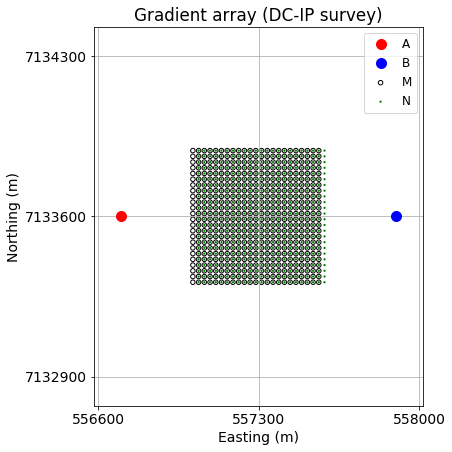

In [12]:
fig, ax = plt.subplots(1,1, figsize=(5*1.3,5*1.3))
plt.xlabel("Easting (m)"); plt.ylabel("Northing (m)")
ax.plot(Aloc1_x[0], Aloc1_x[1], 'ro', ms=10)
ax.plot(Bloc1_x[0], Bloc1_x[1], 'bo', ms=10)
ax.scatter(Mx[:,0], Mx[:,1],s=20, edgecolors="k", facecolors="none")
ax.scatter(Nx[:,0], Nx[:,1],s=5, edgecolors="none", facecolors="g")
ax.legend(("A", "B", "M", "N"), fontsize=12)
xmin, xmax = -700+xc, 700+xc
ymin, ymax = -700+yc, 700+yc
ax.set_xticks(np.linspace(xmin, xmax, 3))
ax.set_yticks(np.linspace(ymin, ymax, 3))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.axis('equal')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.set_title("Gradient array (DC-IP survey)")
ax.grid(True)
plt.tight_layout()
# fig.savefig("./images/GradientArray", dpi=400)

### Plot computed currents, charges, and secondary potentials

Using a finite volume discretization it is possible to numerically model the potential at any point on the mesh. With the relations below it is also possible to compute and visualize current density, charge distributions, and secondary potentials. These plots can be used to gain a better phyiscal understanding of how currents channel in conductive structures and accuulated charges on the interfaces produce secondary potentials. Since structures with varying conductivity from the background alter the total potentials we can use these measurements to reconstruct a conductivity model.      

- Current density: $\mathbf{j} = \sigma \mathbf{e} = -\sigma \nabla \phi$


- Charge:  $\int_V \epsilon_0 \nabla \cdot \mathbf{e} \  dV = \int_V\rho_v dV$ 
 - where $\rho_v$: Volumetric charge density (C/m $^3$), $\epsilon_0$: Dielectric constant in free-space (F/m)


- Secondary potential: $\phi_s = \phi-\phi_0$
 - where $\phi = F[\sigma]$ , $\phi_0 = F[\sigma_{halfspace}]$

In [19]:
def dataPanelPlot(indz,indy):
    fig = plt.figure(figsize=(11, 8))
    Imin, Imax = 2.8e-8,2.7e-5
    Qmin, Qmax =  -18e-11, 3.0e-10
    Vsmin, Vsmax = -2., 2.
    dI, dQ, dV = (Imax-Imin)*0.2, (Qmax-Qmin)*0.2, (Vsmax-Vsmin)*0.2
    xmin, xmax = -700+xc, 700+xc
    ymin, ymax = -700+yc, 700+yc
    zmin, zmax = -700+zc, 0+zc
#     indz = 28
#     indy = 31
    matplotlib.rcParams['font.size'] = 10
    # Axis label
    x = np.linspace(xmin+200, xmax-200,3)

    # Currents z-section
    ax1 = plt.subplot(1,1,1)
    pos =  ax1.get_position()
    ax1.set_position([pos.x0-0.1, pos.y0+0.3,  pos.width*0.5, pos.height*0.5])
    ax1,dat1 = vizEJ(mesh, sigma, indz, f=f, airind=airind, src=src1, normal="Z", ftype="J", xc=xc, yc=yc, zc=zc, clim=(Imin, Imax), ax=ax1, cb=False)
    ax1.plot(Aloc1_x[0], Aloc1_x[1], 'ro', ms=8)
    ax1.plot(Bloc1_x[0], Bloc1_x[1], 'bo', ms=8)
    plt.gca().set_aspect('equal')
    ax1.set_title(("Slice at z=%.1f m")%(mesh.vectorCCz[indz]))
    ax1.xaxis.set_visible(False)
    ax1.set_xlim(xmin, xmax)
    ax1.set_ylim(ymin, ymax)
    ax1.set_ylabel('Northing (m)')

    # Cuurents y-section
    pos =  ax1.get_position()
    ax2 = fig.add_axes([pos.x0+0.0525, pos.y0 - 0.36,  pos.width*0.725, pos.height])
    ax2, dat2 = vizEJ(mesh, sigma, indy, f=f, airind=airind, src=src1, normal="Y", ftype="J", xc=xc, yc=yc, zc=zc, clim=(Imin, Imax), ax=ax2, cb=False)
    ax2.plot(Aloc1_x[0], Aloc1_x[2], 'ro', ms=8)
    ax2.plot(Bloc1_x[0], Bloc1_x[2], 'bo', ms=8)
    plt.gca().set_aspect('equal')
    ax2.set_title(("Slice at y=%.1f m")%(mesh.vectorCCy[indy]))
    ax2.set_xlim(xmin, xmax)
    ax2.set_ylim(zmin, zmax)
    ax2.set_xticks(map(int, x))
    ax2.set_xticklabels(map(str, map(int, x)),size=12)
    ax2.set_xlabel('Easting (m)')
    ax2.set_ylabel('Elev. (m)')

    # Currents colorbar
    cbI = plt.colorbar(dat1[0],orientation="horizontal", format="%1.1e", ticks=np.linspace(Imin+dI, Imax-dI, 3))
    cbI_label = "Electric currents (V/m)"
    cbI.set_label(cbI_label)

    # Charges z-section
    ax3 = fig.add_axes([pos.x0+0.3, pos.y0,  pos.width, pos.height])
    ax3,dat3 = vizEJ(mesh, sigma, indz, f=f, airind=airind, src=src1, normal="Z", ftype="charg", xc=xc, yc=yc, zc=zc, clim=(Qmin, Qmax), ax=ax3, cb=False)
    ax3.plot(Aloc1_x[0], Aloc1_x[1], 'ro', ms=8)
    ax3.plot(Bloc1_x[0], Bloc1_x[1], 'bo', ms=8)
    plt.gca().set_aspect('equal')
    ax3.set_title(("Slice at z=%.1f m")%(mesh.vectorCCz[indz]))
    ax3.xaxis.set_visible(False)
    ax3.yaxis.set_visible(False)
    ax3.set_xlim(xmin, xmax)
    ax3.set_ylim(ymin, ymax)

    # Charges y-section
    ax4 = fig.add_axes([pos.x0+0.3525, pos.y0 - 0.36,  pos.width*0.725, pos.height])
    ax4, dat4 = vizEJ(mesh, sigma, indy, f=f, airind=airind, src=src1, normal="Y", ftype="charg", xc=xc, yc=yc, zc=zc, clim=(Qmin, Qmax), ax=ax4, cb=False)
    ax4.plot(Aloc1_x[0], Aloc1_x[2], 'ro', ms=8)
    ax4.plot(Bloc1_x[0], Bloc1_x[2], 'bo', ms=8)
    plt.gca().set_aspect('equal')
    ax4.set_title(("Slice at y=%.1f m")%(mesh.vectorCCy[indy]))
    ax4.yaxis.set_visible(False)
    ax4.set_xlim(xmin, xmax)
    ax4.set_ylim(zmin, zmax)
    ax4.set_xticks(map(int, x))
    ax4.set_xticklabels(map(str, map(int, x)),size=12)
    ax4.set_xlabel('Easting (m)')

    # Charges colorbar
    cbQ = plt.colorbar(dat4[0],orientation="horizontal", format="%1.1e", ticks=np.linspace(Qmin+dQ, Qmax-dQ, 3))
    cbQ_label = "Electric charges (C)"
    cbQ.set_label(cbQ_label)

    # Secondary potential z-section
    ax5 = fig.add_axes([pos.x0+0.6, pos.y0,  pos.width, pos.height])
    ax5,dat5 = viz(mesh, phi_sec, indz, airind, normal="Z", xc=xc, yc=yc, zc=zc, scale="linear", clim=(Vsmin, Vsmax), ax=ax5, cb=False)
    ax5.plot(Aloc1_x[0], Aloc1_x[1], 'ro', ms=8)
    ax5.plot(Bloc1_x[0], Bloc1_x[1], 'bo', ms=8)
    plt.gca().set_aspect('equal')
    ax5.set_title(("Slice at z=%.1f m")%(mesh.vectorCCz[indz]))
    ax5.xaxis.set_visible(False)
    ax5.yaxis.set_visible(False)
    ax5.set_xlim(xmin, xmax)
    ax5.set_ylim(ymin, ymax)

    # Secondary potential y-section
    ax6 = fig.add_axes([pos.x0+0.6525, pos.y0 - 0.36,  pos.width*0.725, pos.height])
    ax6, dat6 = viz(mesh, phi_sec, indy, airind, normal="Y", xc=xc, yc=yc, zc=zc, scale="linear", clim=(Vsmin, Vsmax), ax=ax6, cb=False)
    ax6.plot(Aloc1_x[0], Aloc1_x[2], 'ro', ms=8)
    ax6.plot(Bloc1_x[0], Bloc1_x[2], 'bo', ms=8)
    plt.gca().set_aspect('equal')
    ax6.set_title(("Slice at y=%.1f m")%(mesh.vectorCCy[indy]))
    ax6.yaxis.set_visible(False)
    ax6.set_xlim(xmin, xmax)
    ax6.set_ylim(zmin, zmax)
    ax6.set_xticks(map(int, x))
    ax6.set_xticklabels(map(str, map(int, x)),size=12)
    ax6.set_xlabel('Easting (m)')

    # Secondary potential colorbar
    cbVs = plt.colorbar(dat6[0],orientation="horizontal", format="%1.1e", ticks=np.linspace(Vsmin+dV, Vsmax-dV, 3))
    cbVs_label = "Potential (V)"
    cbVs.set_label(cbVs_label)

<function __main__.<lambda>>

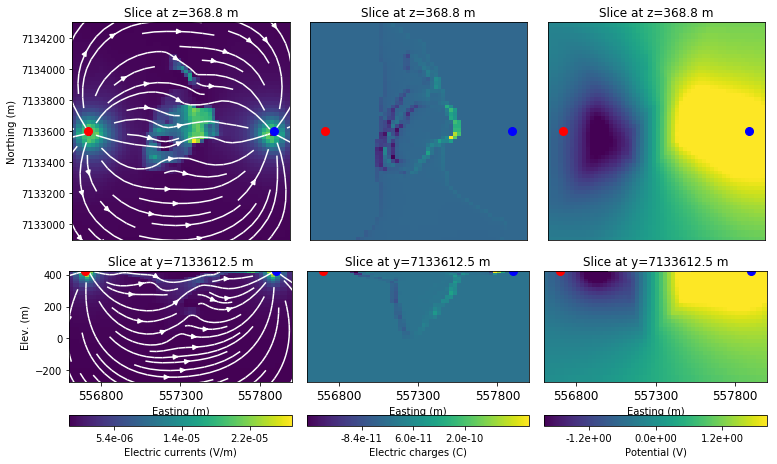

In [20]:
interact(lambda indz,indy: dataPanelPlot(indz,indy), indz=IntSlider(min=0, max=mesh.nCz-1,step=1, value=28), indy=IntSlider(min=0, max=mesh.nCy-1,step=1, value=31))

### Compute DC data

In [21]:
# Evaluate potential at Rx locations
dataObs = Survey.Data(survey, v=dobs)
Xx = 0.5*(Mx[:,0]+Nx[:,0]).reshape((23, 24), order="F")
Yx = Mx[:,1].reshape((23, 24), order="F")

### Visualize DC data

In [22]:
def vizdata(data, src, rx, rxcomponent="X", clim=None, title=None, figsave=None, ax=None, cb=True,cbOrient="vertical"):
    if ax is None:
        fig = plt.figure(figsize=(6.8, 5.5))
        ax = plt.subplot(111)

    temp = data[src, rx]
    if rxcomponent=="X":
        X = Xx.copy()
        Y = Yx.copy()
    else:
        X = Xy.copy()
        Y = Yy.copy()
    temp = temp.reshape(X.shape, order="F")
    if clim is not None:
        vmin, vmax = clim[0], clim[1]
        dat = ax.contourf(X, Y, temp, 20, clim=clim, vmin=vmin, vmax=vmax, cmap="plasma")
        ax.contour(X, Y, temp, 10, colors="k")
    else:
        vmin, vmax = temp.min(), temp.max()
        dat = ax.contourf(X, Y, temp, 20, cmap="plasma")
        ax.contour(X, Y, temp, 10, colors="k")
        
    if title is not None:
        ax.set_title(title)
    xmin, xmax = X.min(), X.max()
    ymin, ymax = Y.min(), Y.max()            
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.set_xticks(np.linspace(xmin, xmax, 3))
    ax.set_yticks(np.linspace(ymin, ymax, 3))
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)            
    
    if cb:
        cb = plt.colorbar(dat, orientation=cbOrient, ticks=np.linspace(vmin, vmax, 3), format="%.1e")
        cb.set_label("Potential (V)")
        
    if figsave is not None:
        fig.savefig(figsave, dpi=200)
    return ax
    

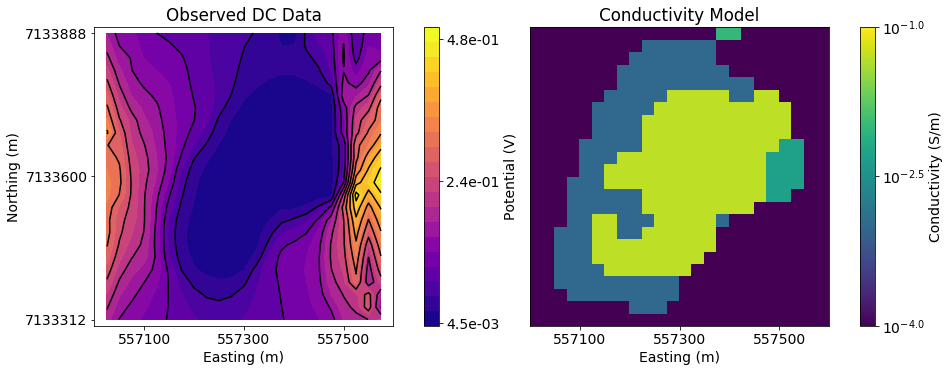

In [23]:
fig = plt.figure(figsize=(11, 5.5))
xmin, xmax = -300+xc, 300+xc
ymin, ymax = -300+yc, 300+yc
indz = 28

matplotlib.rcParams['font.size'] = 14
# Axis label
x = np.linspace(xmin+100, xmax-100,3)

# DC observed data
ax1 = plt.subplot(1,1,1)
pos =  ax1.get_position()
ax1.set_position([pos.x0, pos.y0,  pos.width*0.5, pos.height])
ax1 = vizdata(dataObs, src1, rx_x, ax=ax1, rxcomponent="X", title="Observed DC Data", clim=(4.5e-3, 4.8e-1))
plt.gca().set_aspect('equal')
# ax1.set_title(("Slice at z=%.1f m")%(mesh.vectorCCz[indz]))
# ax1.xaxis.set_visible(False)
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)   
ax1.set_xticks(map(int, x))
ax1.set_xticklabels(map(str, map(int, x)),size=14)
ax1.set_xlabel('Easting (m)')
ax1.set_ylabel('Northing (m)')
ax1.set

# True conductivity model
ax2 = fig.add_axes([pos.x0+0.55, pos.y0,  pos.width, pos.height])
ax2,dat2 = viz(mesh, sigma, indz, airind, normal="Z", xc=xc, yc=yc, zc=zc, ax=ax2)
plt.gca().set_aspect('equal')
ax2.set_title(("Slice at z=%.1f m")%(mesh.vectorCCz[indz]))
ax2.yaxis.set_visible(False)
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(ymin, ymax)
ax2.set_xticks(map(int, x))
ax2.set_xticklabels(map(str, map(int, x)),size=14)
ax2.set_xlabel('Easting (m)')
ax2.set_title('Conductivity Model')